# Enquête emploi en continu 2015

---
## Experimental Setup

### Libraries & Settings

In [1]:
import os              # General OS commands
import numpy as np     # NumPy
import pandas as pd    # Python Data Analysis Library
import zipfile         # Compress/decompress ZIP files
import sqlite3         # SQLite3 Database Driver
import re              # Regular Expressions

In [2]:
# Never truncate columns, display all the data
from IPython.display import display, HTML
pd.set_option('display.max_colwidth', -1)

# Display floating-point numbers with 4 decimals in `pandas.DataFrame`
pd.options.display.float_format = '{:,.4f}'.format

import matplotlib.pyplot as plt
# Display MatPlotLib stuff inline
%matplotlib inline

### Database

In [3]:
zip_filename = "../data/ee-insee-2015_custom-sqlite.zip"
eedb = zip_filename.replace("-sqlite.zip", ".sqlite")

if not os.path.exists(eedb):
    with zipfile.ZipFile(zip_filename) as zip_file:
        zip_file.extractall("../data/")

In [4]:
with sqlite3.connect(eedb) as con:
    query = "SELECT * FROM eec15_custom"
    eec15 = pd.read_sql_query(query, con)

In [5]:
# Create a ("female" x "enfant") interaction variable
bool_ = eec15[["enfants_", "female_"]].astype(bool)
eec15["female_enfants_"] = (bool_.enfants_ & bool_.female_).astype(int)

# Drop data we don't need
eec15 = eec15[eec15.age60_ == 0]
eec15 = eec15.drop("age60_", 1)

### Parameters

In [9]:
# Build a list of parameters to include in the model, using regex
# https://www.datarobot.com/blog/multiple-regression-using-statsmodels/
filters = {
    "age": "^age[0-9]{2}_$",
    "diploma": "^dip[0-9]{2}_$",
    "etranger": "^etranger_$",
    "domtom": "^domtom_$",
#     "trim": "^trim$",
    "female": "^female_$",
    "enfants": "^enfants_$",
#     "female_enfants": "^female_enfants_$",
    "region": "^region[1-2]_$"
}
params = {k: sorted([x for x in eec15.columns if re.match(r, x)]) for (k, r) in filters.items()}

# Avoid the dummy variable trap
params = {k: (v if len(v) == 1 else v[:-1]) for (k, v) in params.items()}
params["region"] += ["region2_"]

In [10]:
trims = ["t{}".format(x) for x in sorted(eec15["trim"].unique())]
eec15_ = {t: eec15[eec15.trim == int(t[1])] for t in trims}
X = {t: eec15_[t][sum(params.values(), [])] for t in eec15_}
y = {t: eec15_[t]["actop_"] for t in eec15_}

### Data

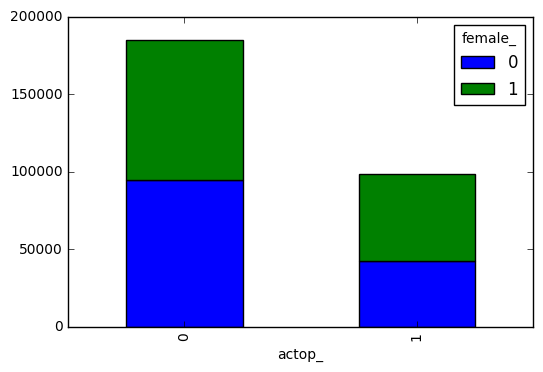

In [6]:
pd.crosstab(eec15.actop_, eec15.female_).plot(kind='bar', stacked=True)

In [7]:
print "Probability of employment:", eec15["actop_"].mean()

Probability of employment: 0.347426515966


---
## Experiment

In [8]:
# Experiment code goes here.